# Assignemt 3 - Task 3

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [31]:
scale = 0.4

## Bounding Box & Segmentation

### MOG Segmentation + Bounding Box Visualization

In [32]:
fgbg = cv2.createBackgroundSubtractorMOG2()
video = cv2.VideoCapture("data/motion/crosswalk.avi")

In [4]:
while video.isOpened():
    ret, curr_frame = video.read()   
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break

    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)

    fgmask = fgbg.apply(curr_frame)
    mask_of_movement = np.where((fgmask == 255), 1, 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask_of_movement, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segemented = curr_frame * cv2.merge([mask_of_movement,mask_of_movement,mask_of_movement])

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 4 and h > 4:
            cv2.rectangle(curr_frame, (x, y), (x + w, y + h), (0,255,0), 1)

    cv2.imshow("Frame", curr_frame)
    cv2.imshow("Mask", mask_of_movement * 255)
    cv2.imshow("Segmented", segemented)

video.release() 
cv2.destroyAllWindows()

### Running Average (with accumulateWeighted)

In [6]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
_, frame1 = video.read()

frame1 = cv2.resize(frame1, None, fx=scale, fy=scale)

In [7]:
running_average = np.float32(frame1) # furure background model

while video.isOpened():
    ret, curr_frame = video.read()   
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break

    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.resize(curr_gray, None, fx=scale, fy=scale)
    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)

    cv2.accumulateWeighted(curr_frame, running_average, 0.02)

running_average = cv2.convertScaleAbs(running_average)

video.release()
cv2.destroyAllWindows()

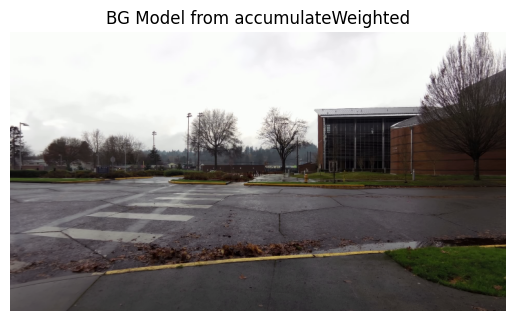

In [8]:
plt.axis("off")
plt.title("BG Model from accumulateWeighted")
plt.imshow(running_average[:,:,::-1])

In [29]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
gray_model = cv2.cvtColor(running_average, cv2.COLOR_BGR2GRAY)

In [30]:
while video.isOpened():
    ret, curr_frame = video.read()   
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break

    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)
    gray_frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(gray_frame, gray_model)

    mask = np.where(diff > 20, 1, 0).astype(np.uint8)

    cv2.imshow("Frame", diff)
    cv2.imshow("Mask", mask * 255)

video.release()
cv2.destroyAllWindows()

## Dense Optical Flow

In [10]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
_, frame1 = video.read()

prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.resize(prev_gray, None, fx=scale, fy=scale)

mask = np.zeros((prev_gray.shape[0], prev_gray.shape[1], 3), np.uint8)
mask[:,:,1] = 255

params = {
    "pyr_scale": 0.5,
    "levels": 1,
    "winsize": 10,
    "iterations": 3,
    "poly_n": 7,
    "poly_sigma": 1.5,
    "flags": 0
}

In [11]:
while video.isOpened():
    ret, curr_frame = video.read()
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break

    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.resize(curr_gray, None, fx=scale, fy=scale)

    flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, **params)
    magnitude, angle = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])

    mask[:,:,0] = angle * 180 / np.pi / 2
    mask[:,:,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    bgr_frame = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    cv2.imshow("Frame", bgr_frame)

    prev_gray = curr_gray

video.release() 
cv2.destroyAllWindows()

## Sparse Optical Flow

In [12]:
video = cv2.VideoCapture("data/motion/crosswalk.avi")
_, frame1 = video.read()

feature_params = {
    "mask": None,
    "maxCorners": 100,
    "qualityLevel": 0.3,
    "minDistance": 15,
    "blockSize": 7
}

lk_params = {
    "winSize": (15, 15),
    "maxLevel": 2,
    "criteria": (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
}

prev_gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
prev_gray = cv2.resize(prev_gray, None, fx=scale, fy=scale)

mask = np.zeros((prev_gray.shape[0], prev_gray.shape[1], 3), np.uint8)
p_prev = cv2.goodFeaturesToTrack(prev_gray, **feature_params)

In [13]:
colors = np.random.randint(0, 255, (100, 3))

while video.isOpened():
    ret, curr_frame = video.read()   
    if not ret or cv2.waitKey(1) & 0xFF == ord('q'):
        break

    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.resize(curr_gray, None, fx=scale, fy=scale)
    curr_frame = cv2.resize(curr_frame, None, fx=scale, fy=scale)
    
    p_curr, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, p_prev, None)

    if p_curr is not None:
        p_prev = p_prev[status == 1]
        p_curr = p_curr[status == 1]

    for i, (prev, curr) in enumerate(zip(p_prev, p_curr)):
        a, b = curr.ravel()
        c, d = prev.ravel()

        mask = cv2.line(mask, (int(a),int(b)), (int(c),int(d)), colors[i].tolist(), 2)
        curr_frame = cv2.circle(curr_frame, (int(a),int(b)), 4, colors[i].tolist(), -1)
        img = cv2.add(curr_frame, mask)

    cv2.imshow("Frame", img)
    p_prev = p_curr.reshape(-1, 1, 2)
    prev_gray = curr_gray

video.release()
cv2.destroyAllWindows()